In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import scipy.misc
from time import time
import coremltools
%matplotlib notebook

<IPython.core.display.Javascript object>


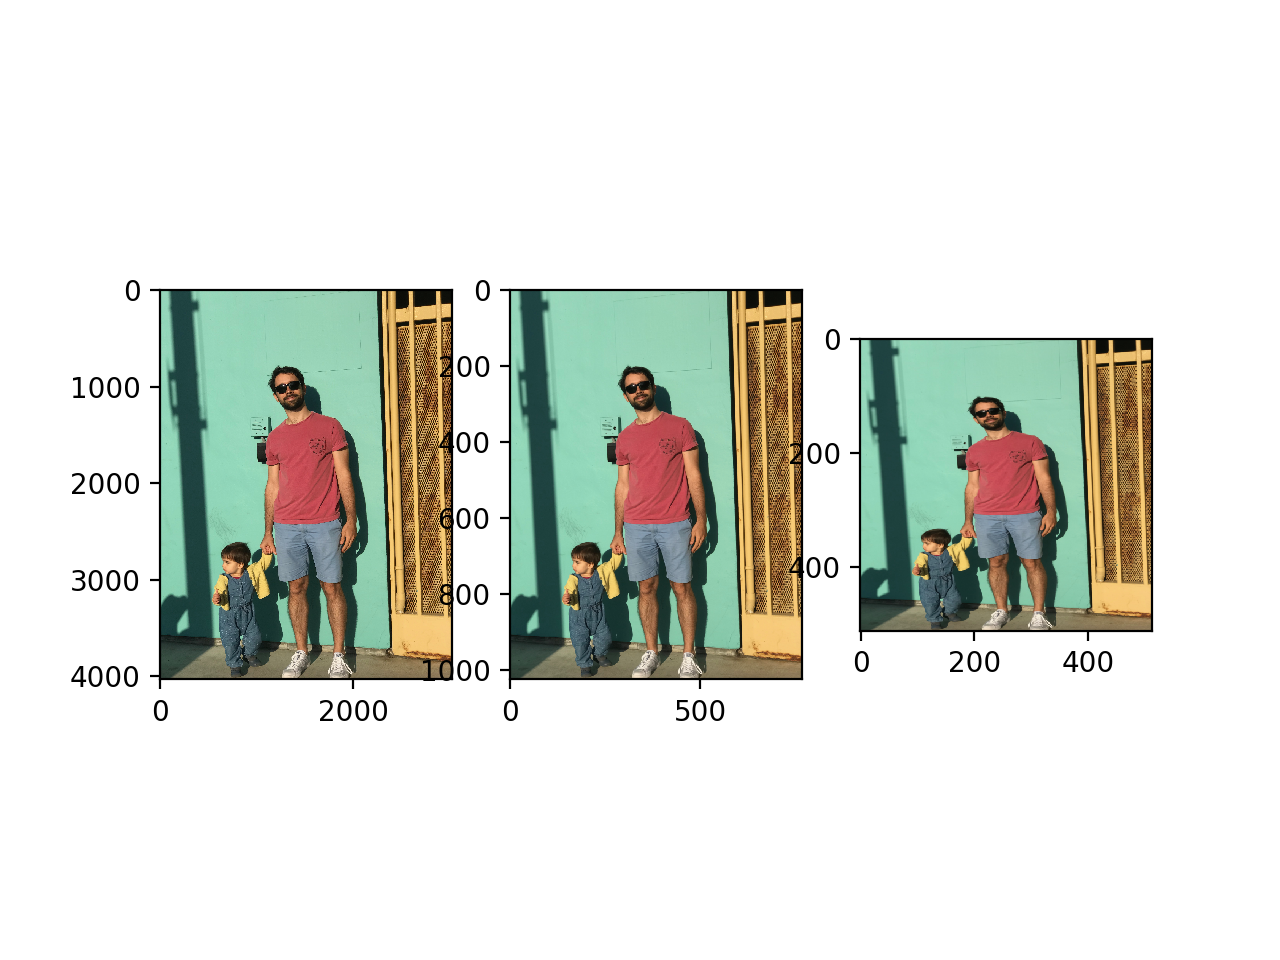

In [4]:
# Load the model and it's specs
model = coremltools.models.MLModel('../../../models/MultiArrayDeepLab.mlmodel')
tiny_width = model.get_spec().description.input[0].type.imageType.width
tiny_height = model.get_spec().description.input[0].type.imageType.height

# Load the image
pil_full = Image.open('../../../samples/person_matthieu.jpg')

# Resize the image to fit within 1024x1024
max_size = 1024
if pil_full.width >= pil_full.height:
    small_width = max_size
    small_height = pil_full.height * max_size / pil_full.width
else:
    small_height = max_size
    small_width = pil_full.width * max_size / pil_full.height
pil_small = pil_full.resize((small_width, small_height), Image.BILINEAR)

# Resize the image to fit model's input size
pil_tiny = pil_full.resize((tiny_width, tiny_height), Image.BILINEAR)

# Plot
f,ax = plt.subplots(1,3)
ax[0].imshow(pil_full)
ax[1].imshow(pil_small)
ax[2].imshow(pil_tiny)
plt.show()

<IPython.core.display.Javascript object>


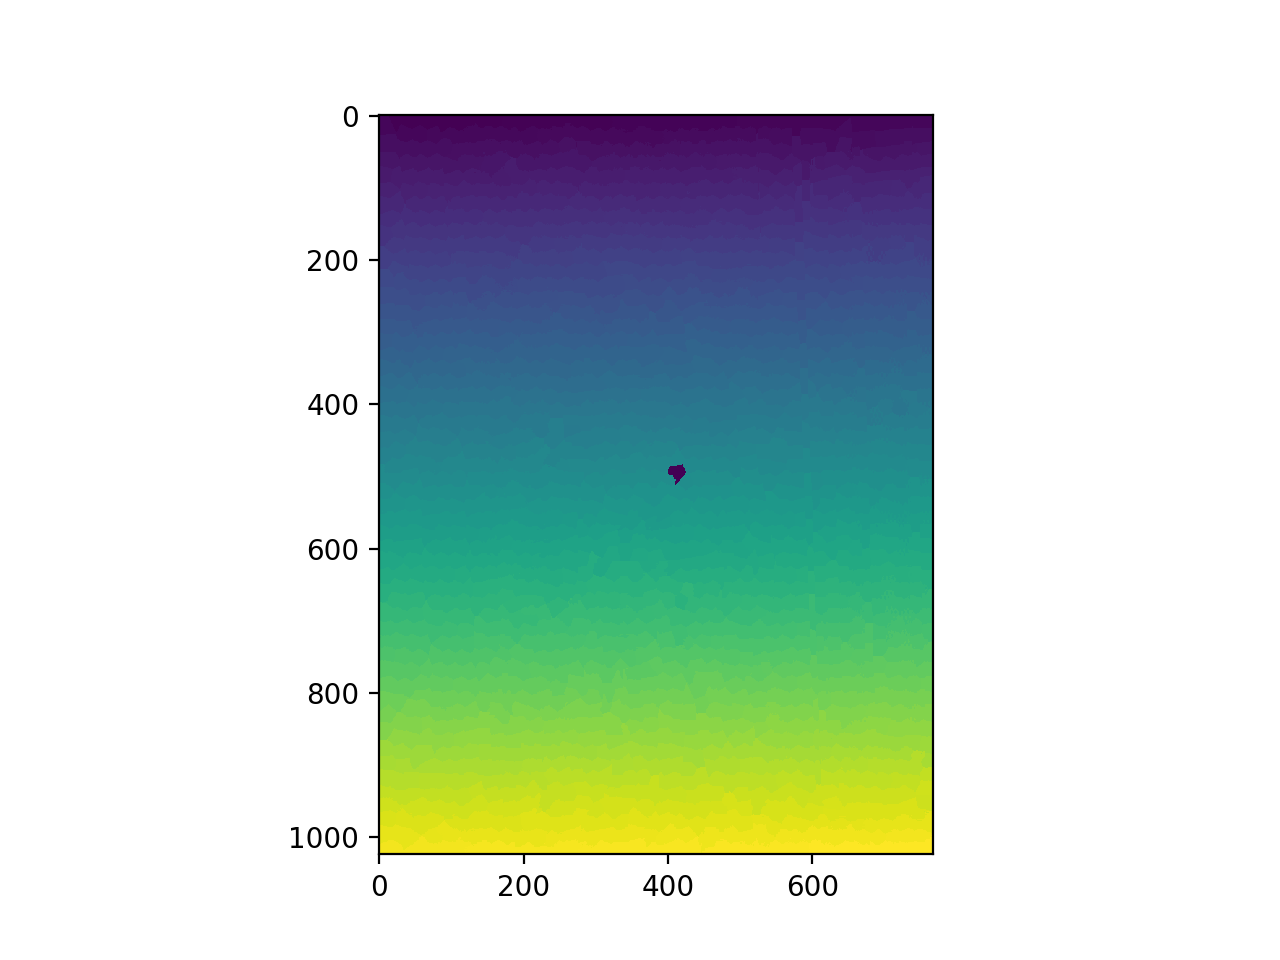

Image size     : 768 x 1024
Region size    : 19
Nb SuperPixels : 2160
Elapsed time   : 0.842429 s


In [8]:
import cv2
from time import time

# Convert images as numpy array
np_full = np.array(pil_full)
np_small = np.array(pil_small)
np_tiny = np.array(pil_tiny)

# Initialize SLIC
region_size = int(min(small_width, small_height) * 0.025)
sp = cv2.ximgproc.createSuperpixelSLIC(np_small, cv2.ximgproc.SLICO, region_size)

# Run the algorithm
tic = time()
sp.iterate(10)
toc = time()

# Get the labels
sp_labels = sp.getLabels()

# Plot
plt.figure()
plt.imshow(sp_labels)
plt.show()

# Display
print('Image size     : %d x %d' % (small_width, small_height))
print('Region size    : %d' % region_size)
print('Nb SuperPixels : %d' % sp.getNumberOfSuperpixels())
print 'Elapsed time   : %f s' % (toc - tic)

In [5]:
# Predict the classes
y = model.predict({'ImageTensor__0': pil_tiny}, usesCPUOnly=False)
pred_tiny = y['ResizeBilinear_3__0']
pred_tiny = pred_tiny.astype(np.float32)

# Resize the prediction
pred_small = np.zeros(((21, pil_small.height, pil_small.width)), dtype=np.float32)
for c in range(21):
    img0 = Image.fromarray(pred_tiny[c,:,:])
    img1 = img0.resize((pil_small.width, pil_small.height), PIL.Image.NEAREST)
    pred_small[c,:,:] = np.array(img1)

# Compute softmax
pred0 = np.exp(pred_small)
pred1 = pred0 / np.sum(pred0, axis=0)
pred_softmax = pred1.astype(np.float32)

<IPython.core.display.Javascript object>


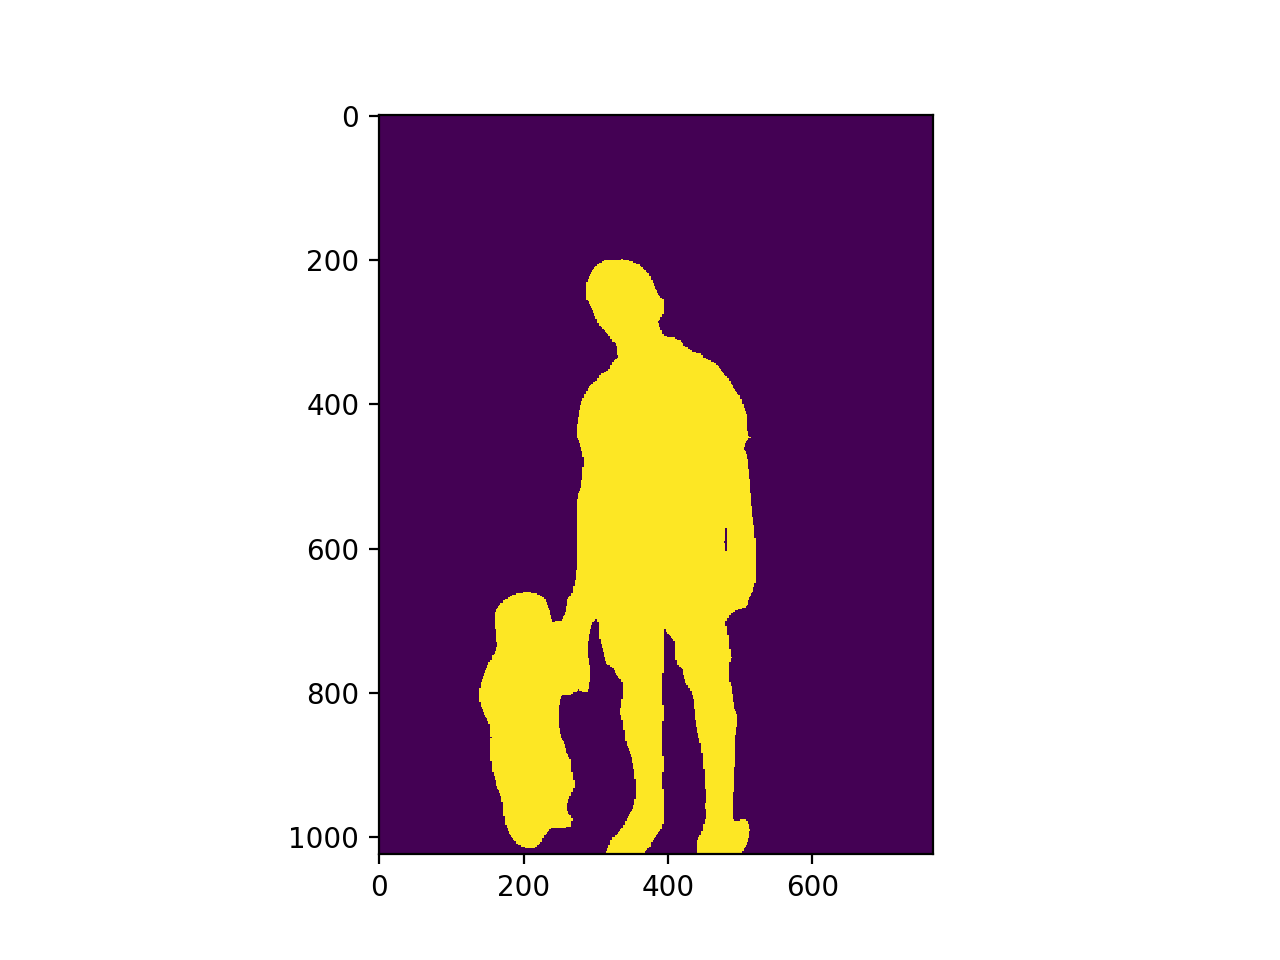

In [13]:
# List of labels
labels = ['Background','Plane','Bicycle','Bird','Boat','Bottle','Bus','Car','Cat','Chair','Cow','Diningtable','Dog','Horse','Motorbike','Person','Pottedplant','Sheep','Sofa','Train','Tvmonitor']
label2id = {'Background':0,'Plane':1,'Bicycle':2,'Bird':3,'Boat':4,'Bottle':5,'Bus':6,'Car':7,'Cat':8,'Chair':9,'Cow':10,'Diningtable':11,'Dog':12,'Horse':13,'Motorbike':14,'Person':15,'Pottedplant':16,'Sheep':17,'Sofa':18,'Train':19,'Tvmonitor':20}

# What class we are interested in
label = 'Person'

# Compute the mask
classif0 = np.argmax(pred_softmax, axis=0)
mask0 = np.zeros((small_height, small_width), dtype=np.uint8)
mask0[classif0 == label2id[label]] = 255

# Plot
plt.figure()
plt.imshow(mask0)
plt.show()

<IPython.core.display.Javascript object>


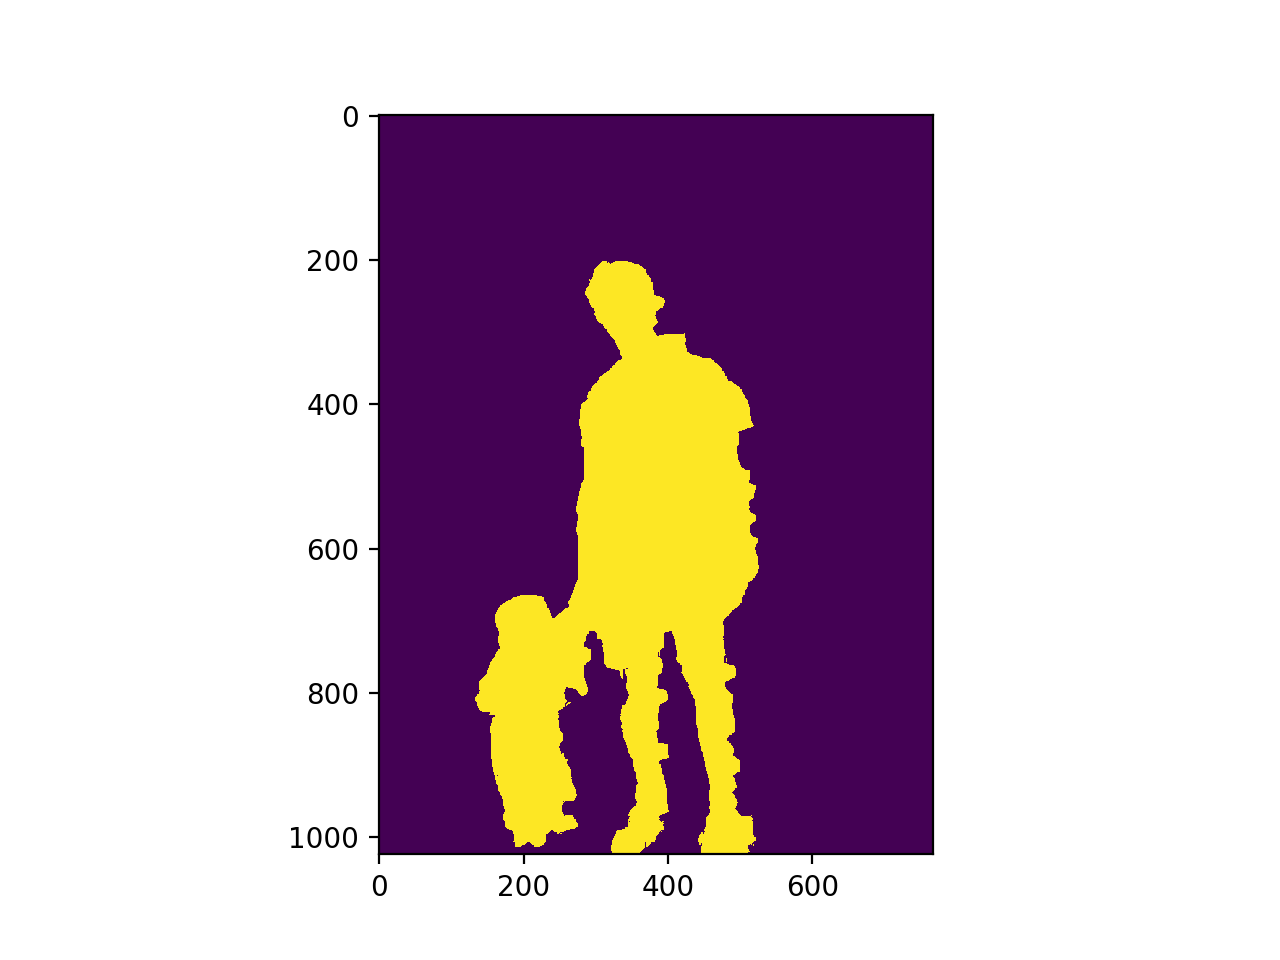

In [14]:
mask1 = np.zeros((small_height, small_width), dtype=np.uint8)

for i in range(sp.getNumberOfSuperpixels()):
    where = sp_labels == i
    val = np.mean(mask0[where])
    if val < 128:
        mask1[where] = 0
    else:
        mask1[where] = 255

# Plot
plt.figure()
plt.imshow(mask1)
plt.show()

<IPython.core.display.Javascript object>


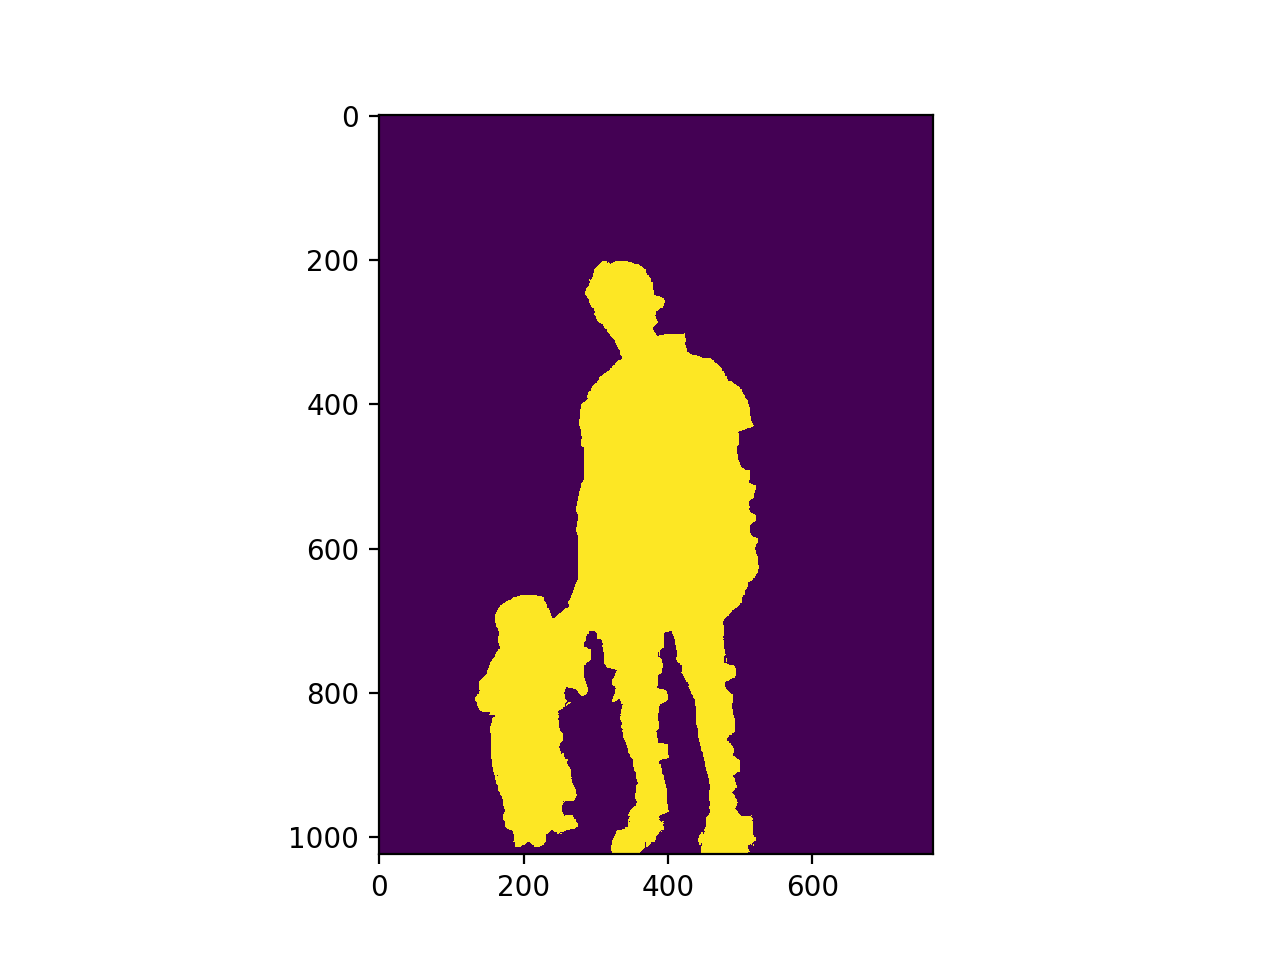

In [18]:
classif2 = np.zeros((small_height, small_width), dtype=np.uint8)

for i in range(sp.getNumberOfSuperpixels()):
    where = sp_labels == i
    max_val = 0.
    max_id = 0
    for c in range(21):
        tmp = pred_softmax[c,:,:][where]        
        val = np.mean(tmp)
        if val > max_val:
            max_val = val
            max_id = c
    classif2[where] = max_id

# Compute the mask
mask2 = np.zeros((small_height, small_width), dtype=np.uint8)
mask2[classif2 == label2id[label]] = 255

# Plot
plt.figure()
plt.imshow(mask2)
plt.show()

<IPython.core.display.Javascript object>


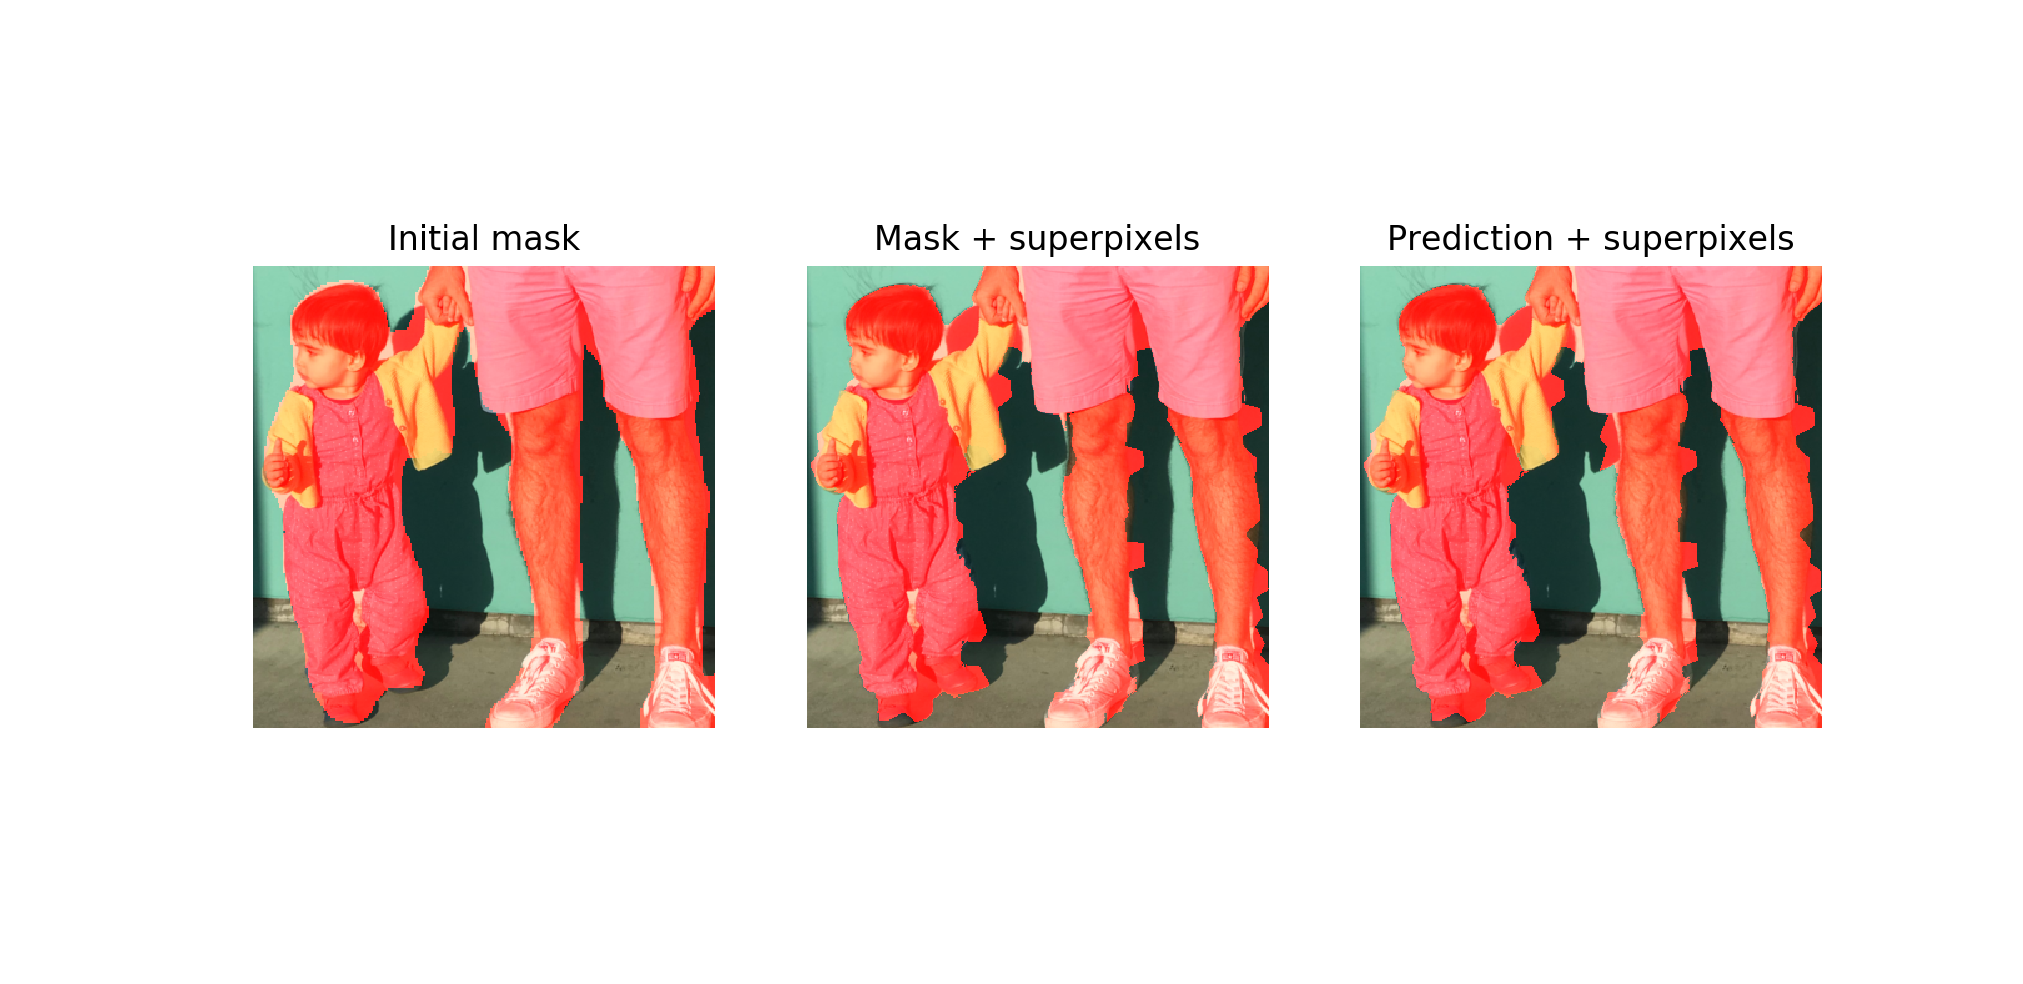

In [24]:
red0 = np_small.copy()
red0[:,:,0][mask0==255] = 255

red1 = np_small.copy()
red1[:,:,0][mask1==255] = 255

red2 = np_small.copy()
red2[:,:,0][mask2==255] = 255

x = 130
y = 650
s = 370


f, ax = plt.subplots(1,3)
ax[0].imshow(red0[y:y+s,x:x+s,:])
ax[1].imshow(red1[y:y+s,x:x+s,:])
ax[2].imshow(red2[y:y+s,x:x+s,:])
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
ax[0].set_title('Initial mask')
ax[1].set_title('Mask + superpixels')
ax[2].set_title('Prediction + superpixels')
plt.show()

<IPython.core.display.Javascript object>


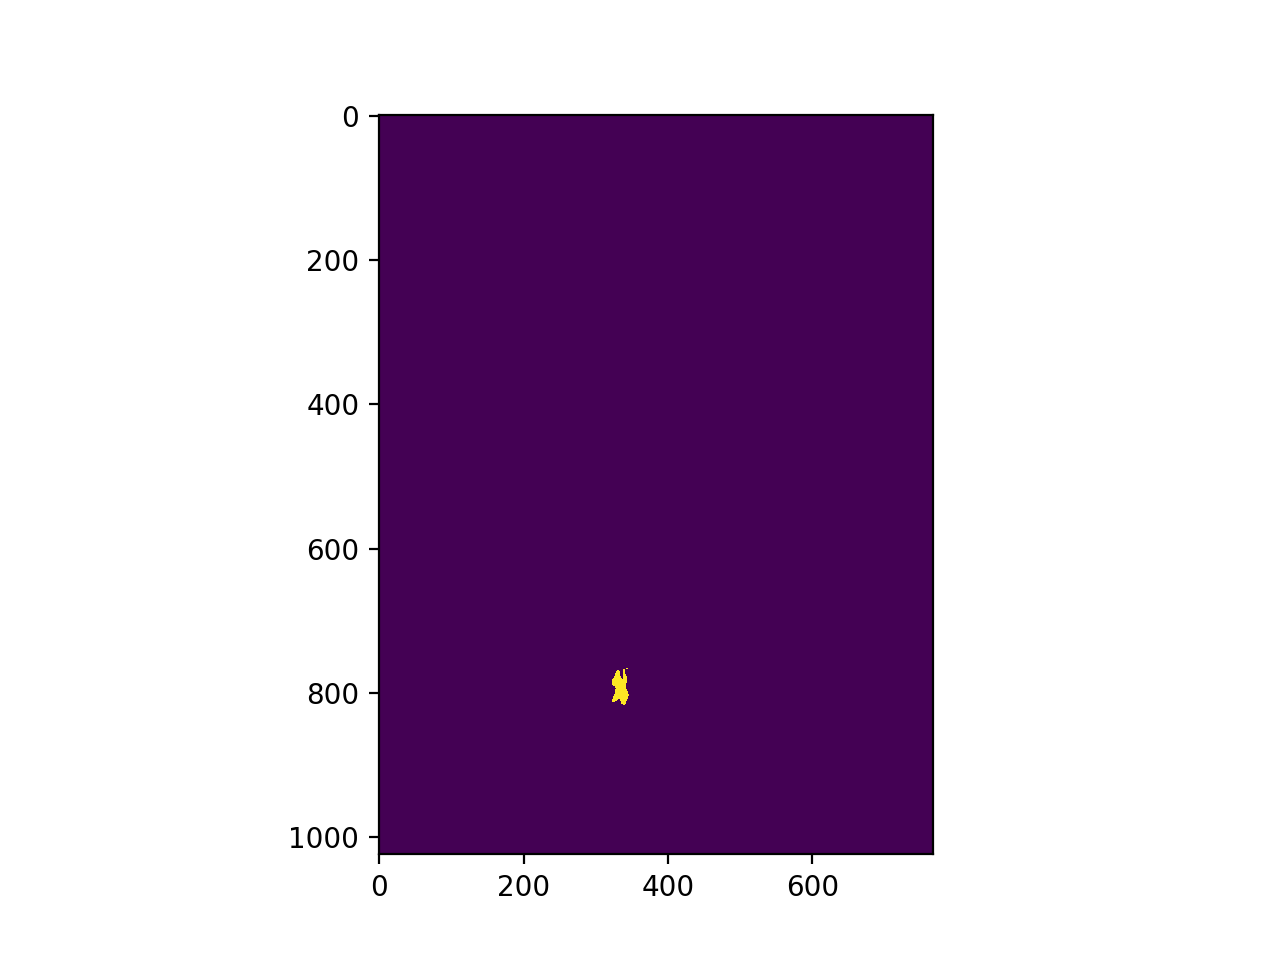

In [20]:
diff = mask2 - mask1
plt.figure()
plt.imshow(diff)
plt.show()